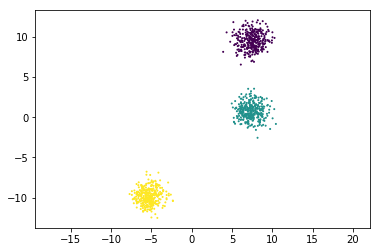

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets

n_samples = 1000

x_org,y = datasets.make_blobs(n_samples=n_samples, random_state=8)

nb_data = len(x_org)
nb_dim = x_org.shape[1]
nb_mix = 3

plt.scatter(x_org[:,0], x_org[:,1], c=y, s=1)
plt.axes().set_aspect('equal', 'datalim')

[# of data,  # of mixture, dimension]

In [2]:
def pdf_gaussian(x, mean, cov):
    shift1 = np.expand_dims((x-mean), -1)
    shift2 = np.expand_dims((x-mean), -2)
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    coef = 1. / (np.sqrt(2.*np.pi))**x.shape[-1] / np.sqrt(det)
    return coef * np.exp(-0.5 * (np.matmul(x-mean,inv) * (x-mean)).sum(-1))

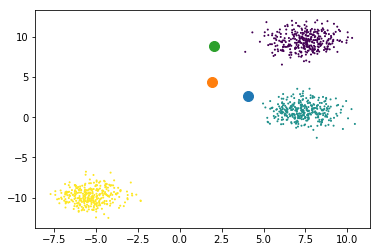

In [3]:
import numpy as np

x = np.reshape(x_org, (nb_data, 1, nb_dim))
mean = np.random.random((1, nb_mix, nb_dim)) * 10.
cov = np.expand_dims(np.stack([np.eye(nb_dim)] * nb_mix), 0)
pi = np.random.random(nb_mix)
pi = pi / pi.sum()

resp = np.zeros((nb_data,nb_mix,1))
for k,p in enumerate(pi):
    pdf = pdf_gaussian(x[:,0,:], mean[0,k,:], cov[0,k,:,:])
    resp[:,k:k+1,:] += np.expand_dims(np.expand_dims(p * pdf, 1),1)
resp = resp / resp.sum(1, keepdims=True)

plt.scatter(x_org[:,0], x_org[:,1], c=y, s=1)
for m in mean[0]:
    plt.scatter(m[0], m[1], s=100)

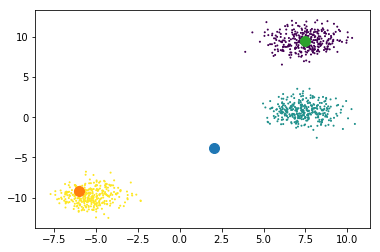

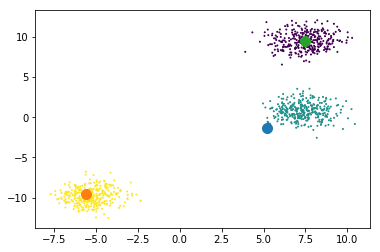

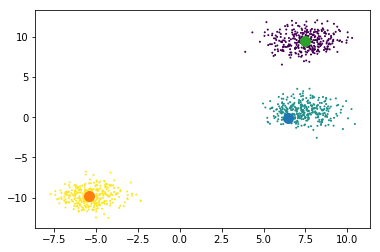

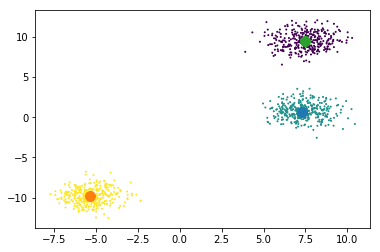

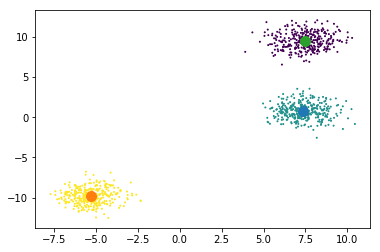

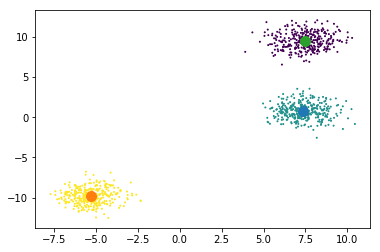

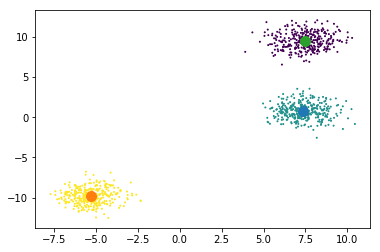

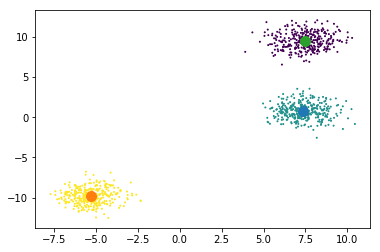

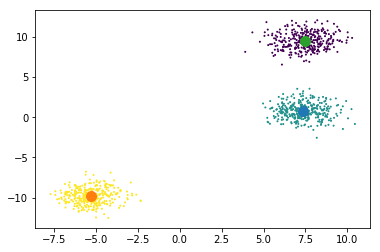

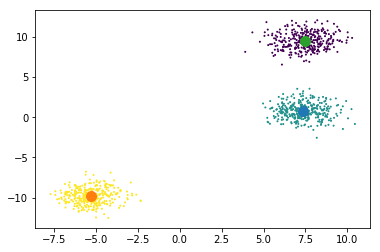

In [4]:
for epoch in range(10):
    mean = (resp * x).sum(0, keepdims=True) / resp.sum(0, keepdims=True)
    cov = (np.expand_dims(resp, -1) * np.expand_dims((x-mean), -1) * np.expand_dims((x-mean), -2)).sum(0, keepdims=True) / np.expand_dims(resp, -1).sum(0, keepdims=True)

    resp = np.zeros((nb_data,nb_mix,1))
    for k,p in enumerate(pi):
        pdf = pdf_gaussian(x, mean[0,k,:], cov[0,k,:,:])
        resp[:,k:k+1,:] += np.expand_dims(p * pdf, 1)
    resp += np.finfo(np.float32).eps
    resp = resp / resp.sum(1, keepdims=True)
    pi = resp.sum(0) / float(nb_data)
    
    plt.scatter(x_org[:,0], x_org[:,1], c=y, s=1)
    for m in mean[0]:
        plt.scatter(m[0], m[1], s=100)
    plt.show()